In [ ]:
from random import random
from abc import ABC
from enum import Enum
import numpy as np

class Strategy(Enum):
    """
    Enum representing the pure strategies a contestant can take.
        ALWAYS_HELP: Always helps the opponent. For talents on or above 0.8
        TIT_FOR_TAT: Helps the opponent if they helped last time, otherwise sabotages. For talents between 0.5 and 0.8
        ALWAYS_SABOTAGE: Always sabotages the opponent. For talents below 0.5
    """
    ALWAYS_HELP = 1
    TIT_FOR_TAT = 2
    ALWAYS_SABOTAGE = 3

class Action(Enum):
    """
    Enum representing an action a contestant can do in relation to the bi-matrix of this simulation.
        HELP: Helps their opponent
        SABOTAGE: Sabotages their opponent
    """
    HELP = 1
    SABOTAGE = 2

class State(Enum):
    """
    Enum representing the different states of the Markov chain.
        ELIMINATION: Contestants who are below the cut off ranking of the next elimination round
        SAFE: Contestants who are below the top 5, but above the cut off of the next elimination round 
        DEBUT: Top 5 contestants.
    """
    ELIMINATION = 1
    SAFE = 2
    DEBUT = 3

class ContestantType(Enum):
    """
    Enum representing the the type of strategy that all contestants will take on.
        PURE_STRATEGY: Contestants stick to only one action.
        MIXED_STRATEGY: Contestants always change their action.
    """
    PURE_STRATEGY = 1
    MIXED_STRATEGY = 2

class TransitionTracker:
    """
    Tracks the transitions between states, and the number of eliminations in each round for a contestant.
    """
    def __init__(self):
        self.transitions = {
            "E_E" : 0,
            "E_S" : 0,
            "E_D" : 0,
            "S_E" : 0,
            "S_S" : 0,
            "S_D" : 0,
            "D_E" : 0,
            "D_S" : 0,
            "D_D" : 0
        }
        self.eliminations = {
            "first round" : 0,
            "second round" : 0,
            "third round" : 0
        }

    def update_transitions(self, previous_state: State, current_state: State):
        """
        Updates the transition counts based on the previous and current state of the contestant.

        Args:
            previous_state (State): The state the contestant was in before the transition.
            current_state (State): The state the contestant is in after the transition.
        """
        if previous_state == State.ELIMINATION:
            if current_state == State.ELIMINATION:
                transition = "E_E"
            elif current_state == State.SAFE:
                transition = "E_S"
            elif current_state == State.DEBUT:
                transition = "E_D"
        elif previous_state == State.SAFE:
            if current_state == State.ELIMINATION:
                transition = "S_E"
            elif current_state == State.SAFE:
                transition = "S_S"
            elif current_state == State.DEBUT:
                transition = "S_D"
        elif previous_state == State.DEBUT:
            if current_state == State.ELIMINATION:
                transition = "D_E"
            elif current_state == State.SAFE:
                transition = "D_S"
            elif current_state == State.DEBUT:
                transition = "D_D"
        else:
            return

        self.transitions[transition] += 1

    def update_elimination_tracker(self, round: int):
        """
        Updates the elimination count based on the round of elimination.

        Args:
            round (int): The round of elimination (0 for first, 1 for second, 2 for third).
        """
        if round == 0:
            self.eliminations["first round"] += 1
        elif round == 1:
            self.eliminations["second round"] += 1
        elif round == 2:
            self.eliminations["third round"] += 1

    def get_from_elim_transition_count(self):
        """
        Returns the total number of transitions from the elimination state to all other states.
        """
        return self.transitions["E_E"] + self.transitions["E_S"] + self.transitions["E_D"]
    
    def get_from_safe_transition_count(self):
        """
        Returns the total number of transitions from the safe state to all other states.
        """
        return self.transitions["S_E"] + self.transitions["S_S"] + self.transitions["S_D"]
    
    def get_from_debut_transition_count(self):
        """
        Returns the total number of transitions from the debut state to all other states.
        """
        return self.transitions["D_E"] + self.transitions["D_S"] + self.transitions["D_D"]

class InitialState:
    """
    Tracks the initial state probabilities of a contestant at the start of the season.
    """
    def __init__(self):
        self.elimination = 0
        self.safe = 0
        self.debut = 0
    
    def increment_elimination(self):
        """
        Increments the count of contestants who started in the elimination state in episode 1.
        """
        self.elimination += 1

    def increment_safe(self):
        """
        Increments the count of contestants who started in the safe state in epsiode 1.
        """
        self.safe += 1

    def increment_debut(self):
        """
        Increments the count of contestants who started in the debut state in episode 1.
        """
        self.debut += 1

    def get_initial_state_probabilities(self):
        """
        Returns the initial state probabilities of a contestant at the start of the season.
        """
        total = self.elimination + self.safe + self.debut
        
        return np.array([self.elimination / total, self.safe / total, self.debut / total])

class Contestant(ABC):
    """
    Represents a contestant in the show, with attributes such as talent, number of votes, vote factor, and state transitions.
    Each contestant has a talent index, an ID, and can simulate voting based on their talent and vote factor.
    """
    def __init__(self, talent_idx, id):
        """
        Initializes a contestant with a talent index and an ID.

        Args:
            talent_idx (float): The talent index of the contestant, ranging from 0 to 1.
            id (int): The unique identifier for the contestant.
        """
        self.talent = talent_idx
        self.id = id
        self.no_of_votes = 0
        self.vote_factor = None # obtained from the bi-matrix interaction which is applied to their gained votes
        self.previous_action = None # the action taken in the previous interaction with another contestant
        self.transition_tracker = TransitionTracker()
        self.previous_state = None # the state the contestant was in before the transition
        self.current_state = None # the state the contestant is in after the transition
        self.transition_matrix = None # the transition matrix for the contestant calculated after simulating 1000 seasons
        self.initial_state = InitialState()

    def simulate_voting(self, no_of_voters = 10000):
        """
        Simulates the voting process for the contestant based on their talent and vote factor.
        
        Args:
            no_of_voters (int): The total number of voters in the simulation. Default is 10,000.
        """
        self.no_of_votes = np.random.binomial(no_of_voters, 0.5)

        # Apply talent factor to votes
        self.no_of_votes += round(self.no_of_votes * 0.1 * self.talent)

        # Apply vote factor to votes
        self.no_of_votes = round(self.no_of_votes * self.vote_factor)

    def set_vote_factor(self, vote_factor):
        self.vote_factor = vote_factor

    def move_state(self):
        """
        Pushes the contestant's current state to be labelled as the previous state.
        """
        self.previous_state = self.current_state

    def update_state(self, new_state: State):
        """
        Sets the contestant's current state to a new state and updates the transition tracker.

        Args:
            new_state (State): The new state to set for the contestant.
        """
        self.current_state = new_state
        self.transition_tracker.update_transitions(self.previous_state, self.current_state)    

    def update_elimination_count(self, round: int):
        """
        Updates the elimination count for the contestant based on the round of elimination.

        Args:
            round (int): The round of elimination (0 for first, 1 for second, 2 for third).
        """
        self.transition_tracker.update_elimination_tracker(round)

    def restart(self):
        """
        Resets the contestant's attributes to their initial state for a new season.
        """
        self.no_of_votes = 0
        self.vote_factor = None
        self.previous_action = None
        self.previous_state = None
        self.current_state = None

    def create_transition_matrix(self):
        self.transition_matrix = TransitionMatrix(self)    

class PureStrategyContestant(Contestant):
    """
    Represents a contestant that follows a pure strategy in the game.
    """
    def __init__(self, talent_idx, id):
        super().__init__(talent_idx, id)

        self.strategy = self.initialise_strategy() # the pure strategy the contestant will take on

    def initialise_strategy(self):
        """
        Determines the pure strategy of the contestant based on their talent index.
        """
        if self.talent < 0.5:
            strategy = Strategy.ALWAYS_SABOTAGE
        elif 0.5 <= self.talent < 0.8:
            strategy = Strategy.TIT_FOR_TAT
        else:
            strategy = Strategy.ALWAYS_HELP

        return strategy

class MixedStrategyContestant(Contestant):
    """
    Represents a contestant that will take on a mixed strategy.
    """
    def __init__(self, talent_idx, id):
        super().__init__(talent_idx, id)
    
class ContestantPool:
    """
    Represents the pool of contestants that will participate in the survival show.
    This same pool of contestants are reused to simulate 1000 seasons.
    """
    def __init__(self, talent_list, type: ContestantType):
        self.type = type
        self.active_contestants = [] # contains contestants who have not yet been eliminated
        self.create_contestants(talent_list, type)
        self.eliminated = [] # contains the eliminated contestants

    def create_contestants(self, talent_list: list, type: ContestantType):
        """
        Creates the pool of contestants using the list of talents provided and the type of contestant strategy.

        Args:
            talent_list (list): A list of talent indices for the contestants, ranging from 0 to 1.
            type (ContestantType): The type of contestant strategy to be used (pure or mixed).
        """
        if type == ContestantType.PURE_STRATEGY:
            for i in range(len(talent_list)):
                self.active_contestants.append(PureStrategyContestant(talent_list[i], i))
        elif type == ContestantType.MIXED_STRATEGY:
            for i in range(len(talent_list)):
                self.active_contestants.append(MixedStrategyContestant(talent_list[i], i))
        
    def get_active_contestants(self):
        return self.active_contestants
    
    def remove_contestants(self, round: int):
        """
        Removes contestants from the active pool based on their state and the round of elimination.
        
        Args:
            round (int): The round of elimination (0 for first, 1 for second, 2 for third).
        """
        # Eliminate all contestants who are not on or above the safe zone (i.e. in the elimination state)
        while True:
            if self.active_contestants[-1].current_state == State.ELIMINATION:
                eliminated_contestant = self.active_contestants.pop()
                eliminated_contestant.update_elimination_count(round)
                self.eliminated.append(eliminated_contestant)
            else:
                break

    def shuffle_active_contestants(self):
        np.random.shuffle(self.active_contestants)

    def sort_active_contestants(self):
        """
        Sorts the active contestants based on the number of votes they received in descending order.
        """
        self.active_contestants.sort(key=lambda x: x.no_of_votes, reverse=True)

    def restart_contestants(self):
        """
        Resets all contestants in the active pool for a new season.
        """
        # Add all eliminated contestants back to the active list
        self.active_contestants += self.eliminated
        self.eliminated.clear()

        # Reset all contestants' attributes
        for contestant in self.active_contestants:
            contestant.restart()
            
class BiMatrix:
    """
    Represents the bi-matrix used to determine the interactions and payoffs between contestants.
    """
    def __init__(self, bi_matrix):
        self.bi_matrix = bi_matrix
        self.row_help_prob = 1/4 # probability of row player helping based on best response condition
        self.column_help_prob = 1/2 # probability of column player helping based on best response condition
    
    def perform_interaction(self, row_player: Contestant, column_player: Contestant, player_type: ContestantType):
        """
        Performs an interaction between two contestants based what their type is (pure or mixed strategy).
        
        Args:
            row_player (Contestant): The more talented contestant acting as the row player in the interaction.
            column_player (Contestant): The less talented contestant acting as the column player in the interaction.
            player_type (ContestantType): The type of strategy that all contestants is taking on.
        """
        if player_type == ContestantType.PURE_STRATEGY:    
            row_action = self.pure_strategy_interaction(row_player, column_player)
            column_action = self.pure_strategy_interaction(column_player, row_player)
            self.apply_outcome(row_player, row_action, column_player, column_action)
        elif player_type == ContestantType.MIXED_STRATEGY:
            row_action = self.mixed_strategy_interaction(determine_row_first=True)
            column_action = self.mixed_strategy_interaction(determine_row_first=False)
            self.apply_outcome(row_player, row_action, column_player, column_action)
            
    def pure_strategy_interaction(self, acting_player: PureStrategyContestant, opponent: PureStrategyContestant):
        """
        Determines the action of a contestant based on their pure strategy and the opponent's previous action.
        
        Args:
            acting_player (PureStrategyContestant): The contestant who is currently taking an action.
            opponent (PureStrategyContestant): The opponent contestant to get the previous action from.
        
        Returns:
            Action: The action taken by the acting player based on their strategy and the opponent's previous action.
        """
        player_strategy = acting_player.strategy

        # Determine action
        if player_strategy == Strategy.TIT_FOR_TAT:
            if opponent.previous_action is None:
                action = Action.HELP
            else:
                action = opponent.previous_action
        elif player_strategy == Strategy.ALWAYS_HELP:
            action = Action.HELP
        elif player_strategy == Strategy.ALWAYS_SABOTAGE:
            action = Action.SABOTAGE
            
        acting_player.previous_action = action

        return action
    
    def mixed_strategy_interaction(self, determine_row_first: bool):
        """
        Determines the action of a contestant based on whether the contestant is the row/column player.

        Args:
            determine_row_first (bool): Whether this is determining the action for the row player or column player.
                True - determine for row player
                False - determine for column player
        """
        # Determine which action to play
        if determine_row_first:
            action = Action.HELP if random() < self.row_help_prob else Action.SABOTAGE
        else:
            action = Action.HELP if random() < self.column_help_prob else Action.SABOTAGE

        return action
    
    def apply_outcome(self, row_player: Contestant, row_input: Action, column_player: Contestant, column_input: Action):
        """
        Determines the outcome of the interaction based on the actions taken by both contestants.
        Args:
            row_player (Contestant): The more talented contestant acting as the row player.
            row_input (Action): The action taken by the row player.
            column_player (Contestant): The less talented contestant acting as the column player.
            column_input (Action): The action taken by the column player.
        """
        # Determine row from the bi-matrix
        if row_input == Action.HELP:
            row = self.bi_matrix[0]
        elif row_input == Action.SABOTAGE:
            row = self.bi_matrix[1]

        # Determine column from the bi-matrix
        if column_input == Action.HELP:
            payoff_tuple = row[0]
        elif column_input == Action.SABOTAGE:
            payoff_tuple = row[1]

        # Set the vote factor for both contestants
        row_player.set_vote_factor(payoff_tuple[0])
        column_player.set_vote_factor(payoff_tuple[1])
        
class Season:
    """
    Represents a season of the survival show, simulating interactions, voting, and state transitions of contestants.
    """
    def __init__(self, contestant_pool: ContestantPool):
        self.contestant_pool = contestant_pool # the pool of contestants that will be used for this season
        self.contestants = self.contestant_pool.get_active_contestants() # the contestants that are currently active in the season
        self.no_of_voters = 10000
        self.elimination_episodes=[3, 6, 10] # the episodes in which eliminations will occur
        self.safe_zone=[16, 10, 5] # the number of contestants who are safe from elimination for each elimination round
        self.bi_matrix = BiMatrix([
            [(1.05, 1.18), (0.85, 1.15)],
            [(1.1, 0.89), (0.8, 0.9)]
        ])
        self.debut_size = 5 # the number of contestants who will be in the debut state at the end of the season

    def simulate_interactions(self):
        """
        Simulates interactions between contestants in pairs, determining the vote factor based on their talent.
        Contestants are shuffled before pairing to ensure randomness in interactions.
        """
        self.contestant_pool.shuffle_active_contestants()

        # Group contestants in pairs
        groups = []
        i = 0
        while i < len(self.contestants):
            groups.append([self.contestants[i], self.contestants[i + 1]])
            i += 2
        
        # Determine vote factor from interaction
        for group in groups:
            contestant_1 = group[0]
            contestant_2 = group[1]

            # Determine who is more talented (becomes the row player)
            contestant_type = self.contestant_pool.type
            if contestant_1.talent > contestant_2.talent:
                self.bi_matrix.perform_interaction(contestant_1, contestant_2, contestant_type)
            else:
                self.bi_matrix.perform_interaction(contestant_2, contestant_1, contestant_type)

    def simulate_voting(self):
        for contestant in self.contestants:
            contestant.simulate_voting(self.no_of_voters)

    def update_transition_tracker(self, episode):
        """
        Updates the transition tracker for each contestant based on their current state and the episode number.

        Args:
            episode (int): The current episode number in the season.
        """
        
        # Get elimination round index
        elim_idx = 0
        while episode > self.elimination_episodes[elim_idx]:
            elim_idx += 1
            if episode <= self.elimination_episodes[elim_idx]:
                break

        # Update transition states
        safe_threshold = self.safe_zone[elim_idx]

        if episode != 0:
            for contestant in self.contestants:
                contestant.move_state()

        for contestant in self.contestants[0:self.debut_size]:
            contestant.update_state(State.DEBUT)
            if episode == 0:
                contestant.initial_state.increment_debut()
        for contestant in self.contestants[self.debut_size:safe_threshold]:
            contestant.update_state(State.SAFE)
            if episode == 0:
                contestant.initial_state.increment_safe()
        for contestant in self.contestants[safe_threshold:]:
            contestant.update_state(State.ELIMINATION)    
            if episode == 0:
                contestant.initial_state.increment_elimination()         

    def simulate_season(self, episodes=10):
        """
        Simulates a season of the survival show over a specified number of episodes.
        Args:
            episodes (int): The number of episodes in the season. Default is 10.
        """
        for episode in range(episodes):
            # Group contestants in pairs and determine voting factor from interaction
            self.simulate_interactions()
            
            # Simulate voting for each contestant
            self.simulate_voting()
            self.contestant_pool.sort_active_contestants()

            # Update contestants' transition tracker based on their ranking in the show
            self.update_transition_tracker(episode)

            # Eliminate contestants if it's an elimination episode
            if episode + 1 in self.elimination_episodes:           
                elim_round = self.elimination_episodes.index(episode + 1)
                self.contestant_pool.remove_contestants(elim_round)

class TransitionMatrix:
    """
    Represents the transition matrix for a contestant, which is used to calculate the probabilities of state transitions.
    """
    def __init__(self, contestant: Contestant):
        self.contestant = contestant
        self.matrix = None
        self.create_transition_matrix(contestant)

    def create_transition_matrix(self, contestant):
        """
        Creates the transition matrix for the contestant based on their transition tracker.
        Args:
            contestant (Contestant): The contestant for whom the transition matrix is being created.
        """
        # Get total counts for each starting state transitions
        total_elim = contestant.transition_tracker.get_from_elim_transition_count()
        total_safe = contestant.transition_tracker.get_from_safe_transition_count()
        total_debut = contestant.transition_tracker.get_from_debut_transition_count()

        elim_row = []
        safe_row = []
        debut_row = []

        # Calculate the transition probabilities
        idx = 0
        for val in contestant.transition_tracker.transitions.values():
            if idx < 3:
                elim_row.append(val / total_elim)
            elif idx < 6:
                safe_row.append(val / total_safe)
            else:
                debut_row.append(val / total_debut)
            idx += 1
        
        self.matrix = np.array([elim_row, safe_row, debut_row])

    def raise_power(self, power: int):
        """
        Raises the transition matrix to a specified power using matrix exponentiation.
        Args:
            power (int): The power to which the transition matrix should be raised.
        
        Returns:
            np.ndarray: The transition matrix raised to the specified power.
        """
        if self.matrix is None:
            raise ValueError("Transition matrix has not been created yet.")
        
        matrix = np.linalg.matrix_power(self.matrix, power)

        return matrix

In [ ]:
# Define talent distributions
uniform_distribution_talents = [
    0.03, 0.07, 0.11, 0.13, 0.16, 0.18, 0.21, 0.23, 0.26, 0.29,
    0.31, 0.34, 0.36, 0.39, 0.41, 0.44, 0.46, 0.49, 0.53, 0.56,
    0.59, 0.62, 0.65, 0.68, 0.71, 0.74, 0.78, 0.82, 0.89, 0.95
]
normal_distribution_talents = [
    0.12, 0.18, 0.22, 0.27, 0.31, 0.34, 0.37, 0.39, 0.41, 0.43,
    0.45, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.55, 0.57,
    0.59, 0.61, 0.63, 0.66, 0.69, 0.73, 0.77, 0.82, 0.88, 0.94
]
many_high_talents = [
    0.35, 0.42, 0.55, 0.62, 0.68, 0.71, 0.72, 0.73, 0.74, 0.75,
    0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85,
    0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.94, 0.97, 0.99
]

def simulate_many_seasons(talent_list, contestant_strat, no_of_seasons=1000):
    """
    Simulates multiple seasons of the survival show with contestants based on the provided talent list and strategy.
    
    Args:
        talent_list (list): A list of talent indices for the contestants, ranging from 0 to 1.
        contestant_strat (ContestantType): The type of contestant strategy to be used (pure or mixed).
        no_of_seasons (int): The number of seasons to simulate. Default is 1000.
    """
    # Simulate 1000 seasons
    contestant_pool = ContestantPool(talent_list, contestant_strat)

    for _ in range(no_of_seasons):
        season = Season(contestant_pool)
        season.simulate_season()
        contestant_pool.restart_contestants()
    print("finish 1000 seasons")

    # Create transition matrices for every contestant
    contestant_pool.active_contestants.sort(key=lambda x: x.id)
    contestants = contestant_pool.active_contestants
    for player in contestants:
        player.create_transition_matrix()
    
    return contestant_pool

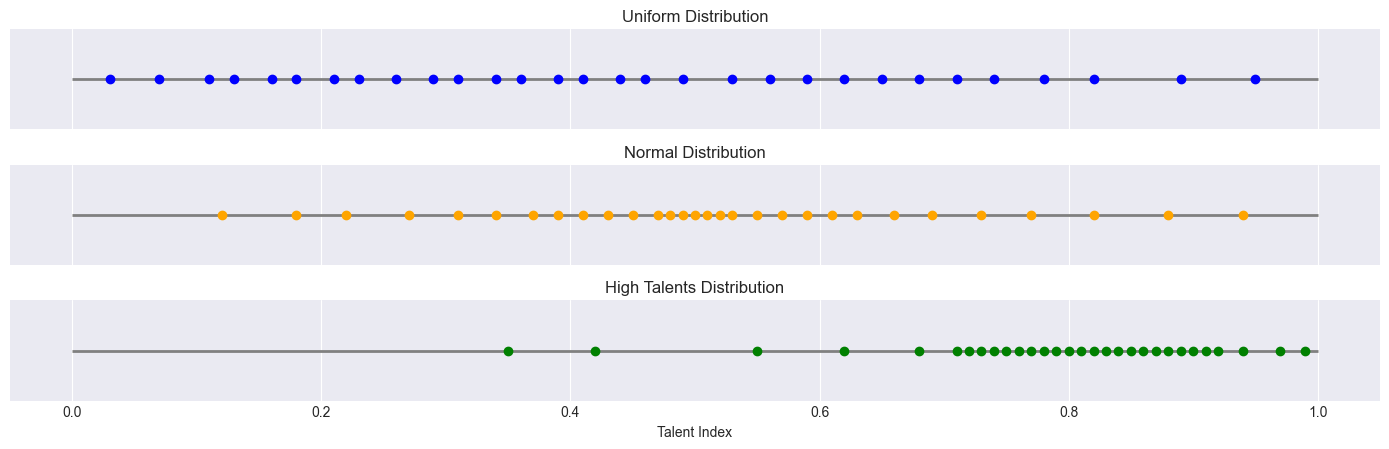

In [ ]:
import matplotlib.pyplot as plt

def plot_talent_distributions_subplots():
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axs = plt.subplots(3, 1, figsize=(14, 5), sharex=True)  # Wider and shorter

    # Uniform Distribution
    axs[0].hlines(1, 0, 1, colors='gray', linewidth=2)
    axs[0].plot(uniform_distribution_talents, [1]*len(uniform_distribution_talents), 'o', color='b')
    axs[0].set_title('Uniform Distribution')
    axs[0].set_yticks([])
    axs[0].set_ylim(0.95, 1.05)
    axs[0].grid(True)

    # Normal Distribution
    axs[1].hlines(1, 0, 1, colors='gray', linewidth=2)
    axs[1].plot(normal_distribution_talents, [1]*len(normal_distribution_talents), 'o', color='orange')
    axs[1].set_title('Normal Distribution')
    axs[1].set_yticks([])
    axs[1].set_ylim(0.95, 1.05)
    axs[1].grid(True)

    # Many High Talents
    axs[2].hlines(1, 0, 1, colors='gray', linewidth=2)
    axs[2].plot(many_high_talents, [1]*len(many_high_talents), 'o', color='green')
    axs[2].set_title('High Talents Distribution')
    axs[2].set_xlabel('Talent Index')
    axs[2].set_yticks([])
    axs[2].set_ylim(0.95, 1.05)
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_talent_distributions_subplots()

In [228]:
# Simulate for the 3 different talent distributions for the two contestant strategies
mixed_uniform_contestants = simulate_many_seasons(uniform_distribution_talents, ContestantType.MIXED_STRATEGY)
mixed_normal_contestants = simulate_many_seasons(normal_distribution_talents, ContestantType.MIXED_STRATEGY)
mixed_high_contestants = simulate_many_seasons(many_high_talents, ContestantType.MIXED_STRATEGY)

pure_uniform_contestants = simulate_many_seasons(uniform_distribution_talents, ContestantType.PURE_STRATEGY)
pure_normal_contestants = simulate_many_seasons(normal_distribution_talents, ContestantType.PURE_STRATEGY)
pure_high_contestants = simulate_many_seasons(many_high_talents, ContestantType.PURE_STRATEGY)

finish 1000 seasons
finish 1000 seasons
finish 1000 seasons
finish 1000 seasons
finish 1000 seasons
finish 1000 seasons


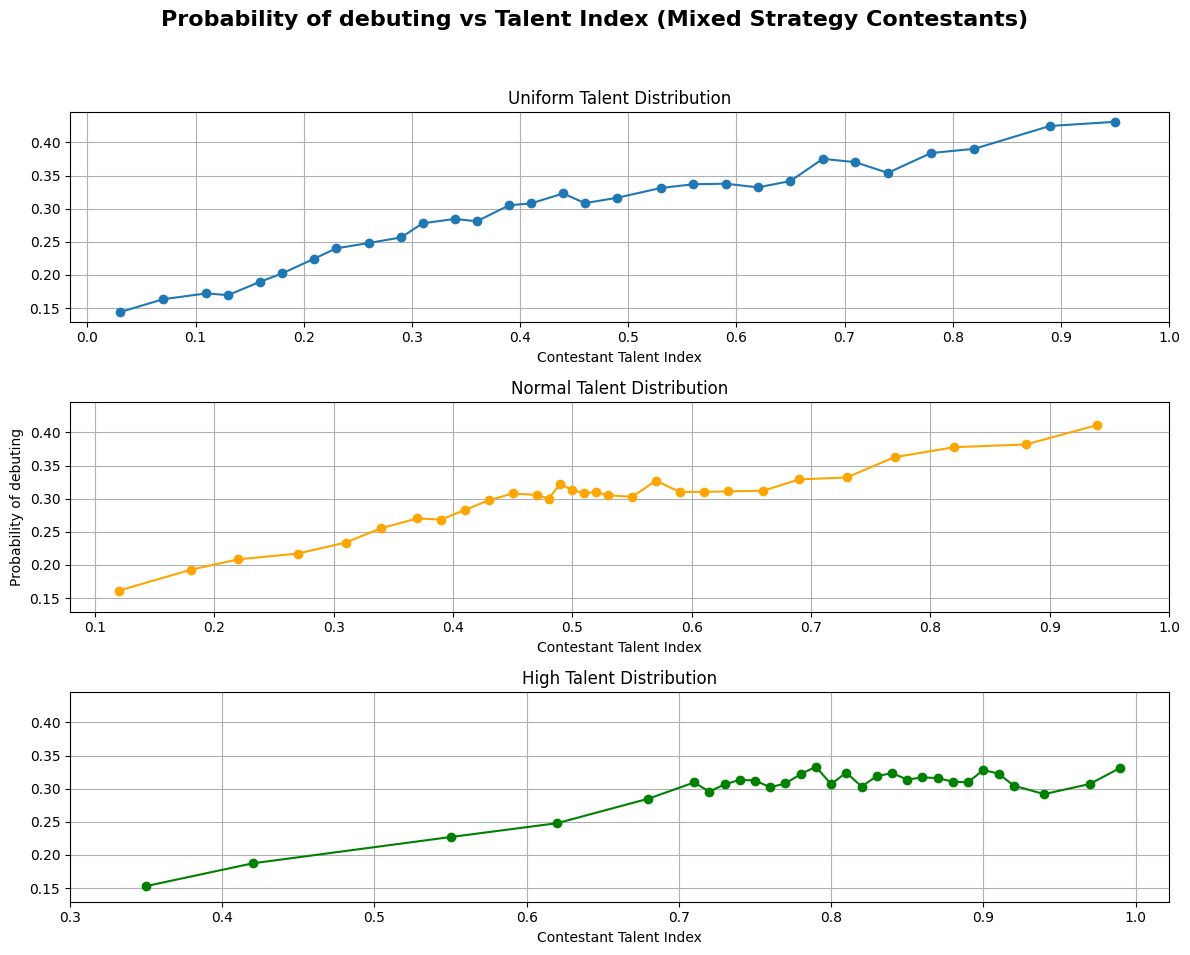

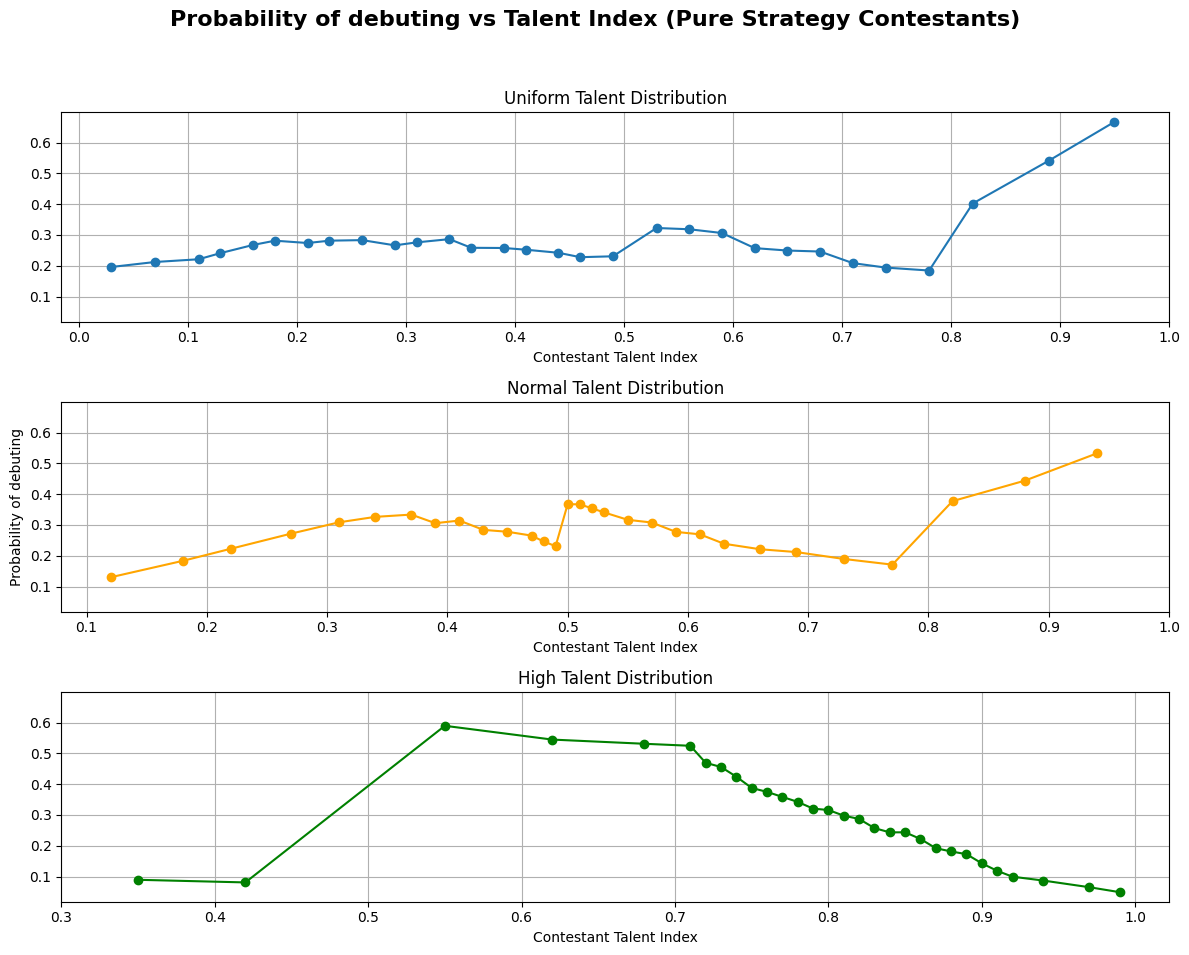

In [229]:
def plot_debut_chances(contestant_strategy):
    # Calculate debut probabilities for different contestant pools
    uniform_debut_prob = []
    normal_debut_prob = []
    high_debut_prob = []

    if contestant_strategy == ContestantType.MIXED_STRATEGY:
        contestant_distribution_types = [mixed_uniform_contestants, mixed_normal_contestants, mixed_high_contestants]
    else:
        contestant_distribution_types = [pure_uniform_contestants, pure_normal_contestants, pure_high_contestants]

    for pool_idx in range(len(contestant_distribution_types)):
        for contestant in contestant_distribution_types[pool_idx].active_contestants:
            transition_matrix = contestant.transition_matrix.raise_power(9)
            state_probabilities = np.dot(contestant.initial_state.get_initial_state_probabilities(), transition_matrix)

            if pool_idx == 0:  # Uniform contestants probabilities
                uniform_debut_prob.append(state_probabilities[2])
            elif pool_idx == 1:  # Normal contestants probabilities
                normal_debut_prob.append(state_probabilities[2])
            elif pool_idx == 2: # Many high talents contestants probabilities
                high_debut_prob.append(state_probabilities[2])

    # Use default matplotlib style for white background
    plt.style.use('default')
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=False, sharey=True)

    # Uniform
    axs[0].plot(uniform_distribution_talents, uniform_debut_prob, 'o-')
    axs[0].set_title("Uniform Talent Distribution")
    axs[0].set_xlabel("Contestant Talent Index")
    axs[0].grid(True)
    axs[0].set_xticks(np.arange(0, 1.01, 0.1))

    # Normal
    axs[1].plot(normal_distribution_talents, normal_debut_prob, 'o-', color='orange')
    axs[1].set_title("Normal Talent Distribution")
    axs[1].set_xlabel("Contestant Talent Index")
    axs[1].set_ylabel("Probability of debuting")
    axs[1].grid(True)
    axs[1].set_xticks(np.arange(0.1, 1.01, 0.1))

    # Many High Talents
    axs[2].plot(many_high_talents, high_debut_prob, 'o-', color='green')
    axs[2].set_title("High Talent Distribution")
    axs[2].set_xlabel("Contestant Talent Index")
    axs[2].grid(True)
    axs[2].set_xticks(np.arange(0.3, 1.01, 0.1))

    if contestant_strategy == ContestantType.MIXED_STRATEGY:
        title = "Mixed"
    else:
        title = "Pure"
    fig.suptitle(f"Probability of debuting vs Talent Index ({title} Strategy Contestants)", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_debut_chances(ContestantType.MIXED_STRATEGY)
plot_debut_chances(ContestantType.PURE_STRATEGY)

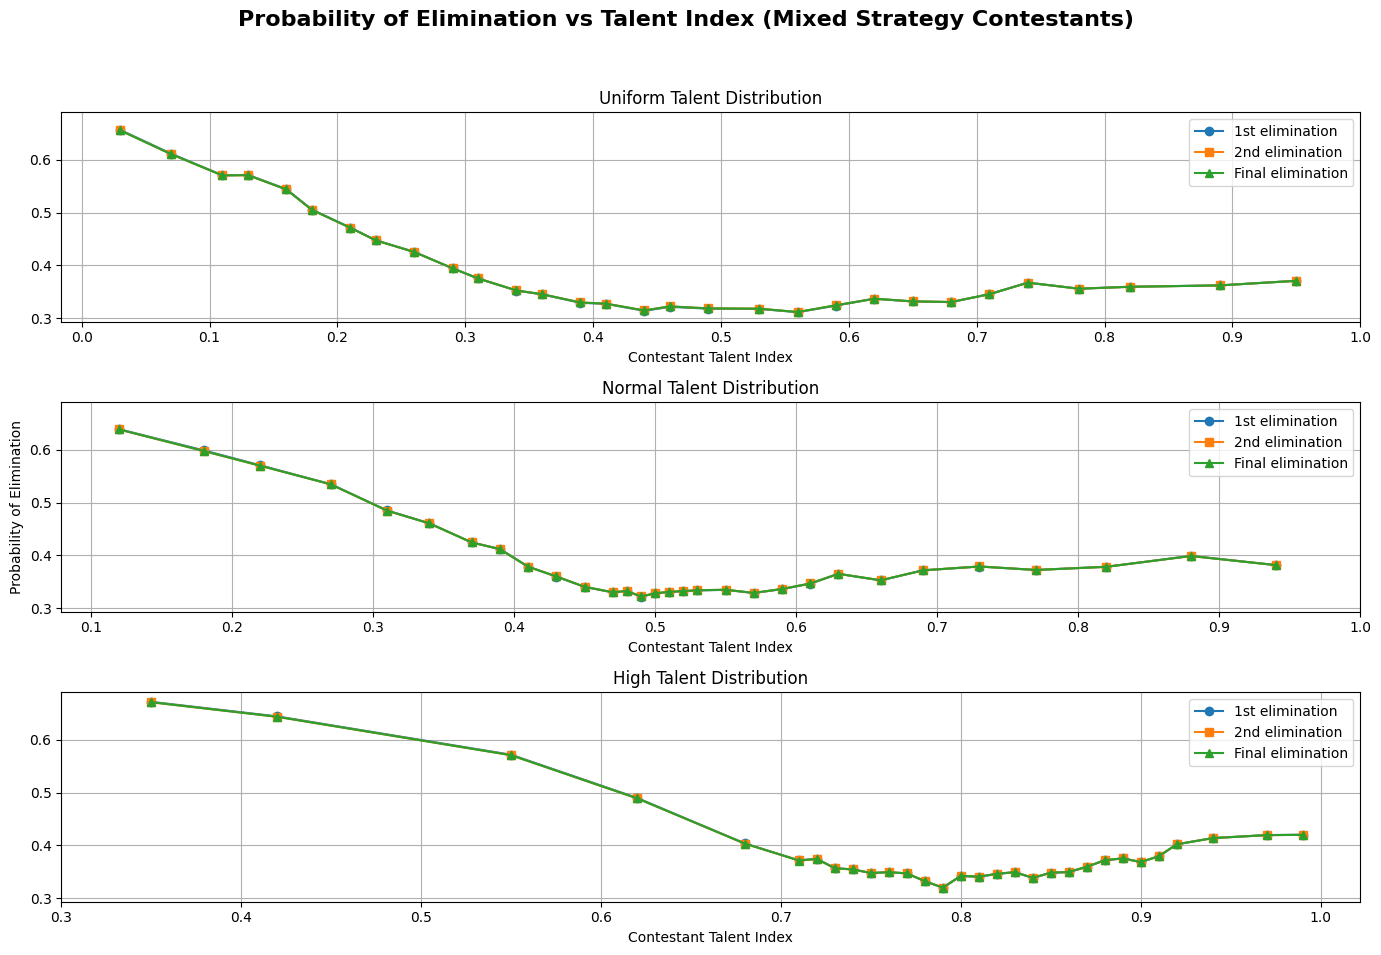

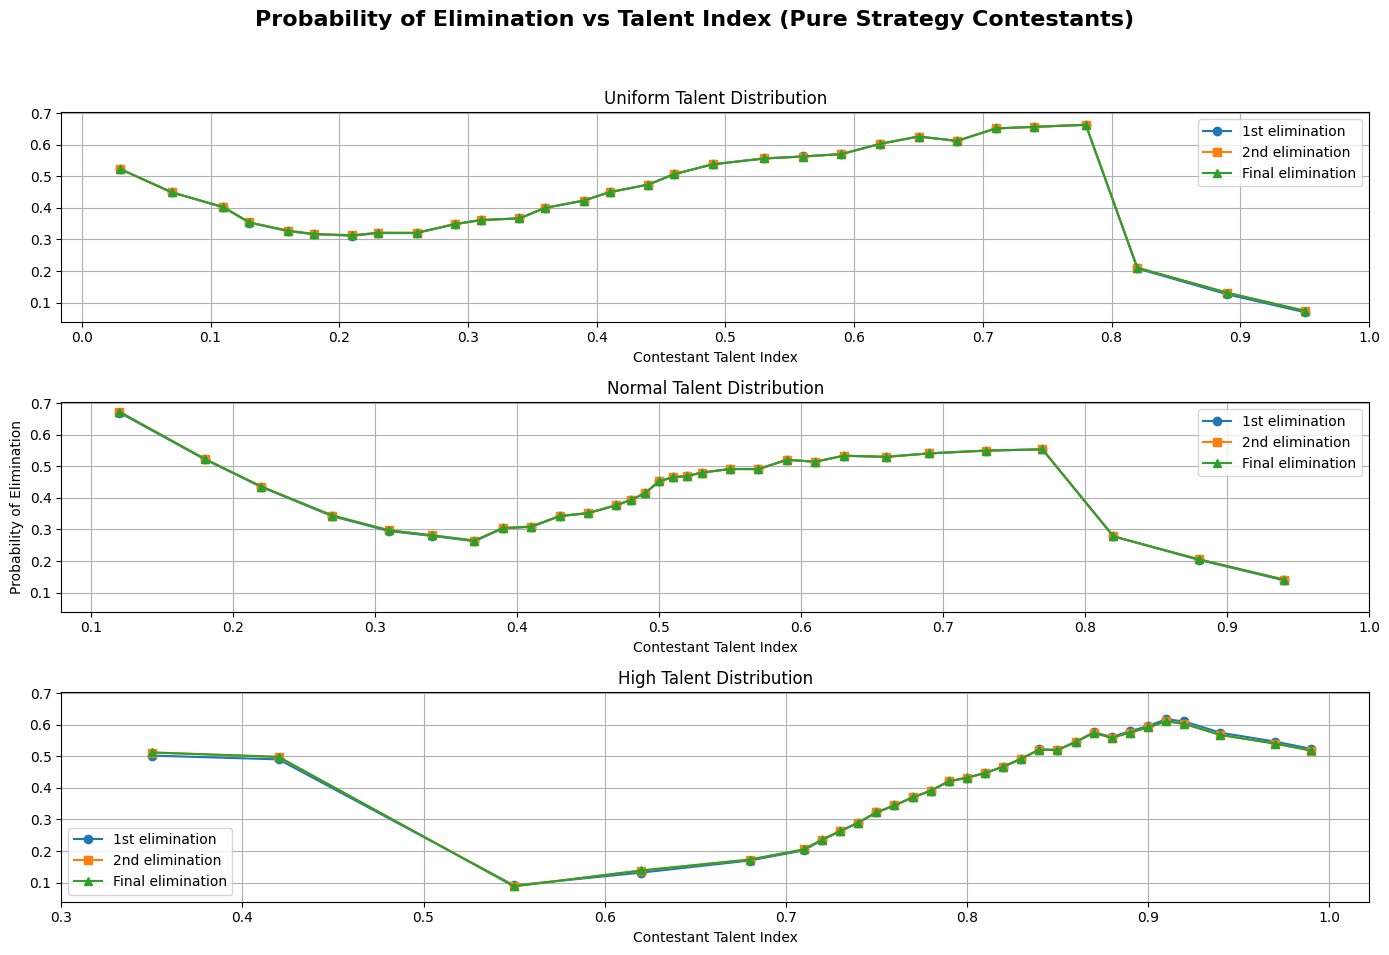

In [230]:
def plot_elimination_chances(contestant_strategy):
    # Use default matplotlib style for white background
    plt.style.use('default')

    if contestant_strategy == ContestantType.MIXED_STRATEGY:
        contestant_distribution_types = [mixed_uniform_contestants, mixed_normal_contestants, mixed_high_contestants]
    else:
        contestant_distribution_types = [pure_uniform_contestants, pure_normal_contestants, pure_high_contestants]

    uniform_elim_prob = [[], [], []]
    normal_elim_prob = [[], [], []]
    high_elim_prob = [[], [], []]
    elim_rounds = [3, 6, 10]

    for pool_idx in range(len(contestant_distribution_types)):
        for contestant in contestant_distribution_types[pool_idx].active_contestants:
            for round_idx in range(len(elim_rounds)):
                transition_matrix = contestant.transition_matrix.raise_power(elim_rounds[round_idx])
                elim_probabilities = np.dot(contestant.initial_state.get_initial_state_probabilities(), transition_matrix)

                if pool_idx == 0:  # Uniform contestants probabilities
                    uniform_elim_prob[round_idx].append(elim_probabilities[0])
                elif pool_idx == 1:  # Normal contestants probabilities
                    normal_elim_prob[round_idx].append(elim_probabilities[0])
                elif pool_idx == 2:  # Many high talents contestants probabilities
                    high_elim_prob[round_idx].append(elim_probabilities[0])

    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=False, sharey=True)

    # Uniform
    axs[0].plot([c.talent for c in contestant_distribution_types[0].active_contestants], uniform_elim_prob[0], 'o-', label='1st elimination')
    axs[0].plot([c.talent for c in contestant_distribution_types[0].active_contestants], uniform_elim_prob[1], 's-', label='2nd elimination')
    axs[0].plot([c.talent for c in contestant_distribution_types[0].active_contestants], uniform_elim_prob[2], '^-', label='Final elimination')
    axs[0].set_title("Uniform Talent Distribution")
    axs[0].set_xlabel("Contestant Talent Index")
    axs[0].grid(True)
    axs[0].legend()
    axs[0].set_xticks(np.arange(0, 1.01, 0.1))

    # Normal
    axs[1].plot([c.talent for c in contestant_distribution_types[1].active_contestants], normal_elim_prob[0], 'o-', label='1st elimination')
    axs[1].plot([c.talent for c in contestant_distribution_types[1].active_contestants], normal_elim_prob[1], 's-', label='2nd elimination')
    axs[1].plot([c.talent for c in contestant_distribution_types[1].active_contestants], normal_elim_prob[2], '^-', label='Final elimination')
    axs[1].set_title("Normal Talent Distribution")
    axs[1].set_xlabel("Contestant Talent Index")
    axs[1].set_ylabel("Probability of Elimination")
    axs[1].grid(True)
    axs[1].legend()
    axs[1].set_xticks(np.arange(0.1, 1.01, 0.1))

    # Many High Talents
    axs[2].plot([c.talent for c in contestant_distribution_types[2].active_contestants], high_elim_prob[0], 'o-', label='1st elimination')
    axs[2].plot([c.talent for c in contestant_distribution_types[2].active_contestants], high_elim_prob[1], 's-', label='2nd elimination')
    axs[2].plot([c.talent for c in contestant_distribution_types[2].active_contestants], high_elim_prob[2], '^-', label='Final elimination')
    axs[2].set_title("High Talent Distribution")
    axs[2].set_xlabel("Contestant Talent Index")
    axs[2].grid(True)
    axs[2].legend()
    axs[2].set_xticks(np.arange(0.3, 1.01, 0.1))

    if contestant_strategy == ContestantType.MIXED_STRATEGY:
        title = "Mixed"
    else:
        title = "Pure"
    fig.suptitle(f"Probability of Elimination vs Talent Index ({title} Strategy Contestants)", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
plot_elimination_chances(ContestantType.MIXED_STRATEGY)
plot_elimination_chances(ContestantType.PURE_STRATEGY)
    